## Process Data


### Import Nescessary Library

In [26]:
# import json to read a json file
import json
import data_utils as dt #Read Json file and create diction of text and markup
import string
import math
from collections import Counter # To find different characters between two sentences
import matplotlib.pyplot as plt # for graph
import nltk
#import seaborn as sns

### Read the data

In [2]:
# Data is a list of dictionaries of text and its markup
data = dt.process_data('Data/tai-documents-v3/tai-documents-v3.json')

In [3]:
len(data)

210

In [4]:
type(data)

list

In [5]:
type(data[0])

dict

In [6]:
data[0].keys()

dict_keys(['plaintext', 'markup'])

#### A example of markup

In [7]:
data[0]['markup']

[{'start_index': 6,
  'end_index': 11,
  'old_text': 'there',
  'new_text': 'there.',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 58,
  'end_index': 59,
  'old_text': '.',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 84,
  'end_index': 85,
  'old_text': 'g',
  'new_text': 'G',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 89,
  'end_index': 90,
  'old_text': 'r',
  'new_text': 'R',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 372,
  'end_index': 397,
  'old_text': 'stripped wheat and yelped',
  'new_text': 'stripped wheat and yelped',
  'type': 'word choice',
  'comment': ''},
 {'start_index': 552,
  'end_index': 575,
  'old_text': 'it is your favorite own',
  'new_text': None,
  'type': 'word choice',
  'comment': ''},
 {'start_index': 602,
  'end_index': 611,
  'old_text': 'gold rush',
  'new_text': 'Gold Rush',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 84,
  'end_index': 93,
  'old_text': 'gold rus

In [8]:
type(data[0])

dict

### Process each essay and find similar error

#### Word Choice

In [9]:
# input: and essay with plain_text and markup
# output: return a list of similar errors of word_choice with number of error for each
# The related words for that error and the indices (on markup) of that error
def word_choice(input):
    output = []
    check = False
    for i in range(len(input['markup'])):
        error = input['markup'][i]
        check = False
        if error['type'] == 'word choice':
            # Check if we see this error before, update the error_count
            for item in output:
                if ((error['old_text'] in item['words']) or
                   (error['new_text'] in item['words'])):
                        check = True # Set this error already marked
                        item['index'].append(i)
                        item['words'].add(error['old_text'])
                        item['words'].add(error['new_text'])
                        item['error_count'] = item['error_count'] + 1
            
            # The error haven't been seen before
            if check == False:
                output.append({'words' : {error['old_text'], error['new_text']}, 
                               'index' : [i], 'error_count' : 1})
                
                
    # Return output
    return output          

In [30]:
[error['old_text'] for error in data[0]['markup'] if error['type'] == 'grammar']

['g', 'r', 'gold rush', 'gold rush']

In [10]:
word_choice_test = {'plaintext' : 'aaaaa', 'markup' : [{'start_index': 6,
                      'end_index': 11,
                      'old_text': 'dad',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''}, 
                      {'start_index': 10,
                      'end_index': 11,
                      'old_text': 'dady',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''},
                      {'start_index': 20,
                      'end_index': 25,
                      'old_text': 'mom',
                      'new_text': 'mother',
                      'type': 'word choice',
                      'comment': ''}]}

In [11]:
word_choice(word_choice_test)

[{'words': {'dad', 'dady', 'father'}, 'index': [0, 1], 'error_count': 2},
 {'words': {'mom', 'mother'}, 'index': [2], 'error_count': 1}]

### Punctuation Error

In [12]:
puct_error = [error for essay in data for error in essay['markup'] if error['type'] == 'punctuation']

In [13]:
len(puct_error)

1449

In [14]:
puct_error[:2]

[{'start_index': 6,
  'end_index': 11,
  'old_text': 'there',
  'new_text': 'there.',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 58,
  'end_index': 59,
  'old_text': '.',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''}]

In [15]:
# Define a set of rules for similar punctuation errors
# The rules we set bases on the markup punctuation error from essay input above
# return a dictionary of all similar errors and numbers of their appearance
def punctuation_error(input):
    output = {}
    # Loop through all errors in an essay then process only punctuation error
    for i in range(len(input['markup'])):
        error = input['markup'][i]
        if (error['type'] == 'punctuation'):  
            old_text = error['old_text']
            new_text = error['new_text']
            if new_text != None:
                new_text_trim = new_text.replace(' ', '')
            old_text_trim = old_text.replace(' ', '')
            
            #if old_text == new_text:
                #raise ValueError("Markup error new and old text are the same")
            # Capitalization error: text on old and new word are the same except capilize a character
            if(new_text != None and old_text.lower() == new_text.lower()):
                # check if we already had capitalization error on output
                # Add new if there is not
                if('capitalization_error' not in output):
                    output['capitalization_error'] = {'definition' : 'Errors on capitalization',
                                                       'index' : [i], 'error_count' : 1}
                else:
                    output['capitalization_error']['index'].append(i)
                    error_cnt = output['capitalization_error']['error_count']
                    output['capitalization_error']['error_count'] = error_cnt + 1
            
            # Error of misleading between 2 punctuations
            elif( new_text != None and  old_text != None 
               and len(old_text) == 1 and  len(new_text) == 1 
               and old_text in string.punctuation  and new_text in string.punctuation):
                error_name = ''
                if((('misleading ' + old_text + new_text) in output)):
                    error_name = 'misleading ' + old_text + new_text
                elif ((('misleading ' + new_text + old_text) in output)):
                    error_name = 'misleading ' + new_text + old_text
                
                # check if output has this type of error - add new if not
                if(error_name == ''):
                    error_name = 'misleading ' + old_text + new_text
                    error_def = 'Errors of misleading between ' + old_text + ' and ' + new_text
                    output[error_name] = {'definition' : error_def, 'index' : [i], 'error_count' : 1}
                else:
                    output[error_name]['index'].append(i)
                    output[error_name]['error_count'] = output[error_name]['error_count'] + 1
               
            # Error of using wrong a punctuation or missing using an punctuation
                # First case: new_word/old_word contain empty string and/or a punctuation
            elif(new_text !=  None and ((old_text_trim == '' and len(new_text_trim) == 1 
                  and new_text_trim in string.punctuation) or ((new_text_trim == '') 
                 and len(old_text_trim) == 1 and old_text_trim in string.punctuation))):
                error_name = 'error_use ' + old_text_trim + new_text_trim
                # check if output has this type of error - add new if not
                if(error_name not in output):
                    error_def = 'Wrong used or missing using of ' + old_text_trim + new_text_trim
                    output[error_name] = {'definition' : error_def, 'index' : [i], 'error_count' : 1}
                else:
                    output[error_name]['index'].append(i)
                    output[error_name]['error_count'] = output[error_name]['error_count'] + 1
                # Second case: new_word/old_word contains a sentence with a punctuation 
                # and the other contain the same sentence without that punctuation
            elif(new_text !=  None and abs(len(old_text_trim) - len(new_text_trim)) == 1):
                # Get the different character between old_word and new_word
                # Then check if the different character between them is punctuation or not
                if(len(old_text_trim) > len(new_text_trim)):
                    dif_char = list(Counter(old_text_trim.lower()) - Counter(new_text_trim.lower()))[0]
                else:
                    dif_char = list(Counter(new_text_trim.lower()) - Counter(old_text_trim.lower()))[0]
                    
                if(dif_char in string.punctuation):
                    error_name = 'error_use ' + dif_char
                    if(error_name not in output):
                        error_def = 'Wrong used or missing using of ' + dif_char
                        output[error_name] = {'definition' : error_def, 'index' : [i], 'error_count' : 1}
                    else:
                        output[error_name]['index'].append(i)
                        output[error_name]['error_count'] = output[error_name]['error_count'] + 1
                # Otherwise add to other error
                else:
                    error_name = 'other_error'
                    if(error_name not in output):
                        output[error_name] = {'definition' : 'other errors', 'index' : [i], 'error_count' : 1}
                    else:
                        output[error_name]['index'].append(i)
                        output[error_name]['error_count'] = output[error_name]['error_count'] + 1
             
            # The rest add to other error
            else:
                error_name = 'other_error'
                if(error_name not in output):
                    output[error_name] = {'definition' : 'other errors', 'index' : [i], 'error_count' : 1}
                else:
                    output[error_name]['index'].append(i)
                    output[error_name]['error_count'] = output[error_name]['error_count'] + 1
    return output
                    
    

##### TestCase for punctuation_error

##### Test run 

In [16]:
data[9]

{'plaintext': "Gaming setups\r\nJames lee #13\r\n\r\nTable of Contents\r\n#1 Gaming PC\r\n#2 gaming monitor\r\n#3 gaming accessories\r\n\r\nIntroduction\r\nDo you like video games.........well if you don't then you should still read this book on how to make a gaming this book tells you how to be a true gamer and how to have a great gaming setup.\r\n\r\nGaming PC\r\nCYBERPOWERPC i think that you should buy this gaming PC because it has intel core, AMD FX 6300 processor, and lots and lots of other things that will make you look like a gamer and your gaming setup look like a true gaming setup this gaming setup runs like a real gaming setup.  Also it is accessible for VR such as vive VR and Oculus VR. also this gaming PC doesn't just run good it also looks how a gaming PC should look like. my favorite thing is that instead of plastic on the one side of the PC its glass so you can see the inside of the PC. also in the inside of the PC there are LED gaming lights. and that's why i think you 

In [17]:
punctuation_error(data[9])

{'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'index': [0],
  'error_count': 1},
 'other_error': {'definition': 'other errors',
  'index': [1, 3, 5, 7, 9],
  'error_count': 5},
 'error_use .': {'definition': 'Wrong used or missing using of .',
  'index': [2],
  'error_count': 1},
 'capitalization_error': {'definition': 'Errors on capitalization',
  'index': [4],
  'error_count': 1}}

In [18]:
punctuation_test = {'plaintext' : 'aaaaa', 'markup' : [
                    {'start_index': 1824,
                  'end_index': 1825,
                  'old_text': '',
                  'new_text': '.',
                  'type': 'punctuation',
                  'comment': ''}, 
                    {'start_index': 138,
                   'end_index': 139,
                   'old_text': '.',
                   'new_text': '?',
                   'type': 'punctuation',
                   'comment': ''},
                      {'start_index': 235,
                  'end_index': 236,
                  'old_text': '',
                  'new_text': ',',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 400,
                  'end_index': 401,
                  'old_text': 't',
                  'new_text': 'T',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 592,
                  'end_index': 594,
                  'old_text': 'f',
                  'new_text': '.  F',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 620,
                  'end_index': 621,
                  'old_text': 'w',
                  'new_text': 'W',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 67,
                  'end_index': 78,
                  'old_text': 'is surprise',
                  'new_text': 'is, surprise',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 398,
                  'end_index': 406,
                  'old_text': 'is three',
                  'new_text': 'is, three',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 407,
                  'end_index': 421,
                  'old_text': "strikes you're",
                  'new_text': "strikes, you're",
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'I',
                  'new_text': None,
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'w',
                  'new_text': 'Well',
                  'type': 'punctuation',
                  'comment': ''},
            ]}

In [19]:
punctuation_error(punctuation_test)


{'error_use .': {'definition': 'Wrong used or missing using of .',
  'index': [0, 4],
  'error_count': 2},
 'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'index': [1],
  'error_count': 1},
 'error_use ,': {'definition': 'Wrong used or missing using of ,',
  'index': [2, 6, 7, 8],
  'error_count': 4},
 'capitalization_error': {'definition': 'Errors on capitalization',
  'index': [3, 5],
  'error_count': 2},
 'other_error': {'definition': 'other errors',
  'index': [9, 10],
  'error_count': 2}}

#### Make sure that total error we count equal total of punctuation error in input

In [20]:
assert(len([k for k in punctuation_test['markup'] if k['type'] == 'punctuation']) == 
       sum(error['error_count'] for error in punctuation_error(punctuation_test).values()))

In [21]:
for essay in data:
    assert(len([p for p in essay['markup'] if p['type'] == 'punctuation']) == 
           sum(error['error_count'] for error in punctuation_error(essay).values()))

#### Some Stat for counting punctuation error

##### Total Number of punctuation errors were marked

In [22]:
total_punc_error = len([error for essay in data 
                        for error in essay['markup'] 
                        if error['type'] == 'punctuation'])
total_punc_error

1449

##### Total Number of punctuation errors that we can classify (Not put on other_error)

In [23]:
ctb_punc_error = sum([error[1]['error_count'] for essay in data 
                      for error in punctuation_error(essay).items() 
                      if error[0] != 'other_error'])
ctb_punc_error

1034

##### Percent of punctuation error that we can classify

In [24]:
Punc_classify_rate = (ctb_punc_error * 100.0) / total_punc_error
Punc_classify_rate

71.35955831608005

##### Distribution of the repeatable of a type of error in an essay

In [25]:
repeat_error_cnt = [error[1]['error_count'] for essay in data 
                      for error in punctuation_error(essay).items() 
                      if error[0] != 'other_error']

(array([240.,  30.,  25.,  14.,   6.,   6.,   2.,   0.,   0.,   2.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

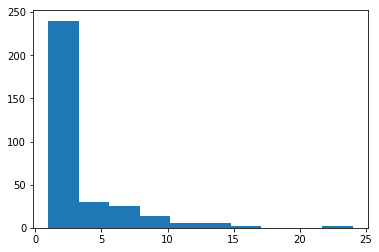

In [204]:
plt.hist(repeat_error_cnt)

In [28]:
error_cnt_freq = nltk.FreqDist(repeat_error_cnt)
error_cnt_freq.most_common(5)

[(1, 134), (2, 66), (3, 40), (4, 17), (7, 14)]

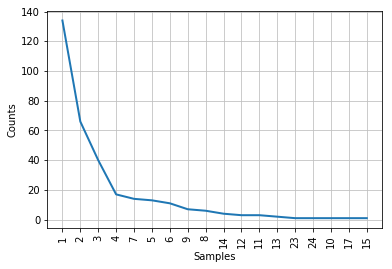

In [29]:
error_cnt_freq.plot()

In [169]:
a = punctuation_error(data[0])

In [184]:
for b in a.items():
    print(b[1])
    print(type(b))

{'definition': 'Wrong used or missing using of .', 'index': [0], 'error_count': 1}
<class 'tuple'>
{'definition': 'other errors', 'index': [1], 'error_count': 1}
<class 'tuple'>


In [108]:
punctuation_error(data[9])

{'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'index': [0],
  'error_count': 1},
 'other_error': {'definition': 'other errors',
  'index': [1, 3, 5, 7, 9],
  'error_count': 5},
 'error_use .': {'definition': 'Wrong used or missing using of .',
  'index': [2],
  'error_count': 1},
 'capitalization_error': {'definition': 'Errors on capitalization',
  'index': [4],
  'error_count': 1}}

In [100]:
dif_char = list(Counter(n) - Counter(o))[0]
dif_char

'?'

In [74]:
o  = 'cheerleading if'
n = 'cheerleading? if'

In [77]:
n.rsplit(o)

['cheerleading? if']

In [80]:
list(o) - list(n)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [81]:
from collections import Counter

In [88]:
a = Counter(n) - Counter(o)
a

Counter({'?': 1})

In [89]:
len(a)

1

AttributeError: 'int' object has no attribute 'key'

In [65]:
a = ' '
a.strip()

''

In [66]:
a

' '

In [43]:
'' in string.punctuation

True

In [33]:
data[0]['markup']

[{'start_index': 6,
  'end_index': 11,
  'old_text': 'there',
  'new_text': 'there.',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 58,
  'end_index': 59,
  'old_text': '.',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 84,
  'end_index': 85,
  'old_text': 'g',
  'new_text': 'G',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 89,
  'end_index': 90,
  'old_text': 'r',
  'new_text': 'R',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 372,
  'end_index': 397,
  'old_text': 'stripped wheat and yelped',
  'new_text': 'stripped wheat and yelped',
  'type': 'word choice',
  'comment': ''},
 {'start_index': 552,
  'end_index': 575,
  'old_text': 'it is your favorite own',
  'new_text': None,
  'type': 'word choice',
  'comment': ''},
 {'start_index': 602,
  'end_index': 611,
  'old_text': 'gold rush',
  'new_text': 'Gold Rush',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 84,
  'end_index': 93,
  'old_text': 'gold rus

In [24]:
data[0]

{'plaintext': 'Gold Rush\r\n\r\nIntroduction\r\n\r\nIn the beginning\r\n\r\nIt is the year. 1848. The life changing gold rush has begun. James Marshall was assigned to build a sawmill with John Sutter’s other workers.In that process he found three gold nuggets. He showed the gold to John Sutter.John Sutter wanted to keep it a secret but Sam Brannan spread the word.\r\n\r\nImmigrants\r\n\r\n“Gold,” Ma said. Rosie stripped wheat and yelped “OoooHhhh!”. People all over wanted to go to the Gold Rush. But not until President Polk said “Gold in california!”\r\n\r\nGold Rush Items\r\n\r\nYou stare at a ball it is your favorite own. People have items in the gold rush like games,clothes, and tools.Which will let you know what time period it is.\r\n\r\nConclusion',
 'markup': [{'start_index': 6,
   'end_index': 11,
   'old_text': 'there',
   'new_text': 'there.',
   'type': 'punctuation',
   'comment': ''},
  {'start_index': 58,
   'end_index': 59,
   'old_text': '.',
   'new_text': None,
   'ty

In [20]:
a.lower()

'bb'